In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv('data/cleaned_rounds_data.csv')
df = df.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X = df.drop(['round_winner'], axis=1)
y = df['round_winner']

In [26]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4), 
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        60,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,657 (276.00 KB)

 Trainable params: 70,657 (276.00 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [35]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5311 - loss: 3.6296 - val_accuracy: 0.7005 - val_loss: 2.5566
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6804 - loss: 2.3407 - val_accuracy: 0.7573 - val_loss: 1.7827
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7427 - loss: 1.6688 - val_accuracy: 0.7586 - val_loss: 1.3457
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7775 - loss: 1.2480 - val_accuracy: 0.7604 - val_loss: 1.0752
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7909 - loss: 0.9884 - val_accuracy: 0.7641 - val_loss: 0.9035
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7933 - loss: 0.8324 - val_accuracy: 0.7647 - val_loss: 0.7967
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7965 - loss: 0.7264 - val_accuracy: 0.7714 - val_loss: 0.7265
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8114 - loss: 0.6506 - val_accu

In [36]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step


In [44]:
print(classification_report(y_test, y_pred))

confusion_m = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(confusion_m, index=['Actual Negative', 'Actual Positive'],
                              columns=['Predicted Negative', 'Predicted Positive'])
print(conf_matrix_df)
print({
    'true negatives': f'{round(100*confusion_m[0, 0]/len(y_test))}%',
    'false positives': f'{round(100*confusion_m[0, 1]/len(y_test))}%',
    'false negatives': f'{round(100*confusion_m[1, 0]/len(y_test))}%',
    'true positives': f'{round(100*confusion_m[1, 1]/len(y_test))}%'
})

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1702
           1       0.78      0.79      0.79      1804

    accuracy                           0.78      3506
   macro avg       0.78      0.78      0.78      3506
weighted avg       0.78      0.78      0.78      3506

                 Predicted Negative  Predicted Positive
Actual Negative                1290                 412
Actual Positive                 372                1432
{'true negatives': '37%', 'false positives': '12%', 'false negatives': '11%', 'true positives': '41%'}
Macro average F1 score: 0.78
Weighted average F1 score: 0.78


ROC-AUC Score: 0.8476730128373818


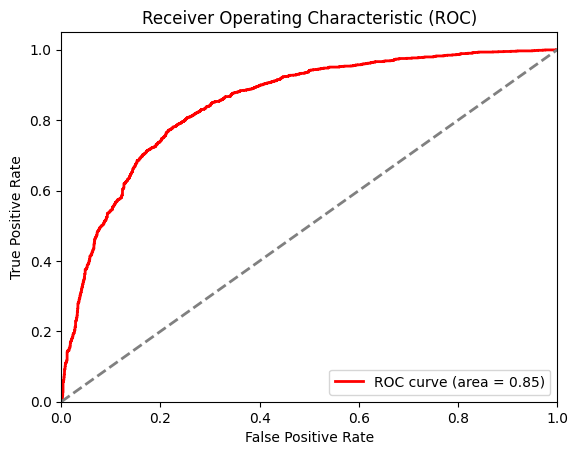

In [42]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC-AUC Score: {roc_auc}')
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()